# Получение модели с помощью CatBoost

## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

## Обучение модели

In [5]:
df = pd.read_csv("../Data/data.csv")

In [6]:
# Преобразуем категор. переменную vessel_type в бинарный числовой вид
df['vessel_type'] = np.where(df['vessel_type'] == 'сухогруз', 0, 1)

In [7]:
# Типы переменных df
df.dtypes

vessel_type          int32
L                  float64
B                  float64
d                  float64
DW                 float64
speed              float64
cargo_amount         int64
cost_per_mile      float64
cargo_demand         int64
cargo_value          int64
cargo_fragility      int64
cargo_danger         int64
sea_route            int64
wind_strength        int64
sea_state            int64
target             float64
dtype: object

In [8]:
# Разбиение данных на предикторы и целевую переменную
X = df.drop("target", axis=1)
y = df["target"]

In [9]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1186, 15)
y shape: (1186,)


In [10]:
# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Вариант 1 - Ручной подбор k_value + используется 15 предикторов

In [8]:
# Словарь с результатами обучения 100 моделей KNN Regressor
results = {"model": [], "k_value": [], "R2": [], "RMSE": []}

# Создание 10 моделей и обучение их с целью выявления лучшей
for k_value in range(1, 100):
    model = KNeighborsRegressor(n_neighbors=k_value)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Расчет метрик качества R2, RMSE
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions)

    # Записываем в словарь
    results["model"].append(model)
    results['k_value'].append(k_value)
    results['R2'].append(r2)
    results['RMSE'].append(rmse)

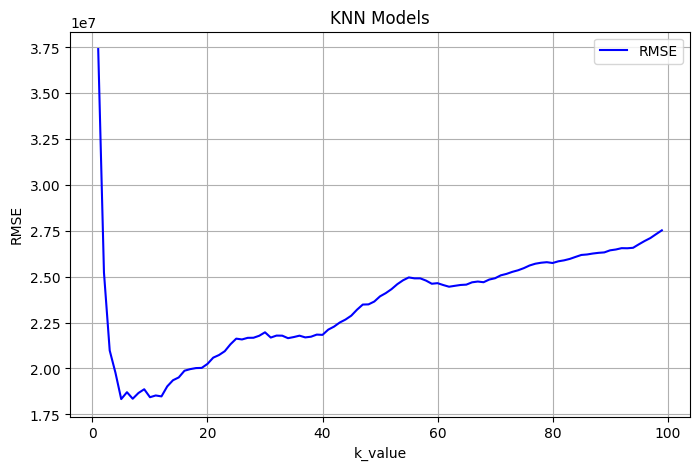

In [9]:
# Визуализация изменения RMSE от кол-ва соседей (k_value)
plt.figure(figsize=(8, 5))
plt.plot((results["k_value"]), results["RMSE"], label='RMSE', color='blue')
plt.xlabel('k_value')
plt.ylabel('RMSE')
plt.title('KNN Models')
plt.legend()
plt.grid()
plt.savefig("../Images/Graphs/KNN_Model_Selection.png", dpi=199)
plt.show()

In [10]:
# Инфа о лучшей модели
df_results = pd.DataFrame(results).sort_values("RMSE", ascending=True).iloc[0]
df_results

model      KNeighborsRegressor()
k_value                        5
R2                      0.725256
RMSE             18333075.385131
Name: 4, dtype: object

In [11]:
best_model_1 = df_results["model"]

### Вариант 2 - Подбор гиперпараметров с GridSearchCV + используется 10 предикторов

In [12]:
X_copy = X.copy()
y_copy = y.copy()

In [13]:
X_copy = X_copy.drop(["d", "wind_strength", "sea_state", "DW", "speed"], axis=1)

In [14]:
print("X_copy shape", X_copy.shape)
print("y_copy shape", y_copy.shape)

X_copy shape (1186, 10)
y_copy shape (1186,)


In [15]:
# Объявление модели
knn_model = KNeighborsRegressor()

In [16]:
# Настройка объекта GridSearchCV
parameters = {"n_neighbors": range(1, 50),
              "weights": ["uniform", "distance"],
              "p": [1, 2]}

regressor_2 = GridSearchCV(knn_model, parameters,
                           scoring=["r2", "neg_root_mean_squared_error"],
                           refit="r2",
                           cv=5)

In [17]:
regressor_2.fit(X_copy, y_copy)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [18]:
best_model_2 = regressor_2.best_estimator_

In [19]:
# Инфа о модели
print("Параметры лучшей KNN модели:", regressor_2.best_params_)
print("R2 лучшей модели = ", regressor_2.best_score_)

Параметры лучшей KNN модели: {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'}
R2 лучшей модели =  0.6815684766984038


### Вариант 3 - Подбор гиперпараметров с GridSearchCV + используется 15 предикторов

In [20]:
# Объявление модели
knn_model = KNeighborsRegressor()

In [21]:
# Настройка объекта GridSearchCV
parameters = {"n_neighbors": range(1, 50),
              "weights": ["uniform", "distance"],
              "p": [1, 2]}

regressor_3 = GridSearchCV(knn_model, parameters,
                           scoring=["r2", "neg_root_mean_squared_error"],
                           refit="r2",
                           cv=5)

In [22]:
regressor_3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [23]:
best_model_3 = regressor_3.best_estimator_

In [24]:
# Инфа о модели
print("Параметры лучшей KNN модели:", regressor_3.best_params_)
print("R2 лучшей модели = ", regressor_3.best_score_)

Параметры лучшей KNN модели: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
R2 лучшей модели =  0.6807264029127252


## Сравнение получившихся лучших моделей, полученных разными способами

In [14]:
print(f"R2 1-ой модели KNN = {r2_score(y_test, best_model_1.predict(X_test)):.2f}")
print(f"R2 2-ой модели KNN = {r2_score(y_copy, best_model_2.predict(X_copy)):.2f}")
print(f"R2 3-ой модели KNN = {r2_score(y_test, best_model_3.predict(X_test)):.2f}")

R2 1-ой модели KNN = 0.79
R2 2-ой модели KNN = 0.74
R2 3-ой модели KNN = 0.94


## Сохранение моделей KNN

In [32]:
import pickle

# 1-ая модель
with open('../KNN_models/KNN_model_1.pkl','wb') as f:
    pickle.dump(best_model_1,f)

# 2-ая модель
with open('../KNN_models/KNN_model_2.pkl','wb') as f:
    pickle.dump(best_model_2,f)

# 3-ая модель
with open('../KNN_models/KNN_model_3.pkl','wb') as f:
    pickle.dump(best_model_3,f)

## Загрузка моделей KNN

In [1]:
import pickle

# 1-ая модель
with open("../KNN_models/KNN_model_1.pkl", "rb") as f:
    best_model_1 = pickle.load(f)

# 2-ая модель
with open("../KNN_models/KNN_model_2.pkl", "rb") as f:
    best_model_2 = pickle.load(f)

# 3-ая модель
with open("../KNN_models/KNN_model_3.pkl", "rb") as f:
    best_model_3 = pickle.load(f)